Files already downloaded and verified
Files already downloaded and verified
Training model without compression:
Epoch 1, Loss: 1.4810, Test Accuracy: 56.04%
Epoch 1 duration: 21.53 seconds
Epoch 2, Loss: 1.1098, Test Accuracy: 64.1%
Epoch 2 duration: 20.88 seconds
Epoch 3, Loss: 0.8943, Test Accuracy: 65.95%
Epoch 3 duration: 20.84 seconds
Epoch 4, Loss: 0.7636, Test Accuracy: 68.13%
Epoch 4 duration: 20.70 seconds
Epoch 5, Loss: 0.6589, Test Accuracy: 71.68%
Epoch 5 duration: 20.98 seconds
Epoch 6, Loss: 0.5566, Test Accuracy: 72.64%
Epoch 6 duration: 20.99 seconds
Epoch 7, Loss: 0.4661, Test Accuracy: 73.28%
Epoch 7 duration: 20.82 seconds
Epoch 8, Loss: 0.3843, Test Accuracy: 74.21%
Epoch 8 duration: 20.94 seconds
Epoch 9, Loss: 0.3216, Test Accuracy: 73.28%
Epoch 9 duration: 20.73 seconds
Epoch 10, Loss: 0.2619, Test Accuracy: 73.57%
Epoch 10 duration: 21.00 seconds
Epoch 11, Loss: 0.2233, Test Accuracy: 74.23%
Epoch 11 duration: 21.04 seconds
Epoch 12, Loss: 0.1851, Test Accuracy:

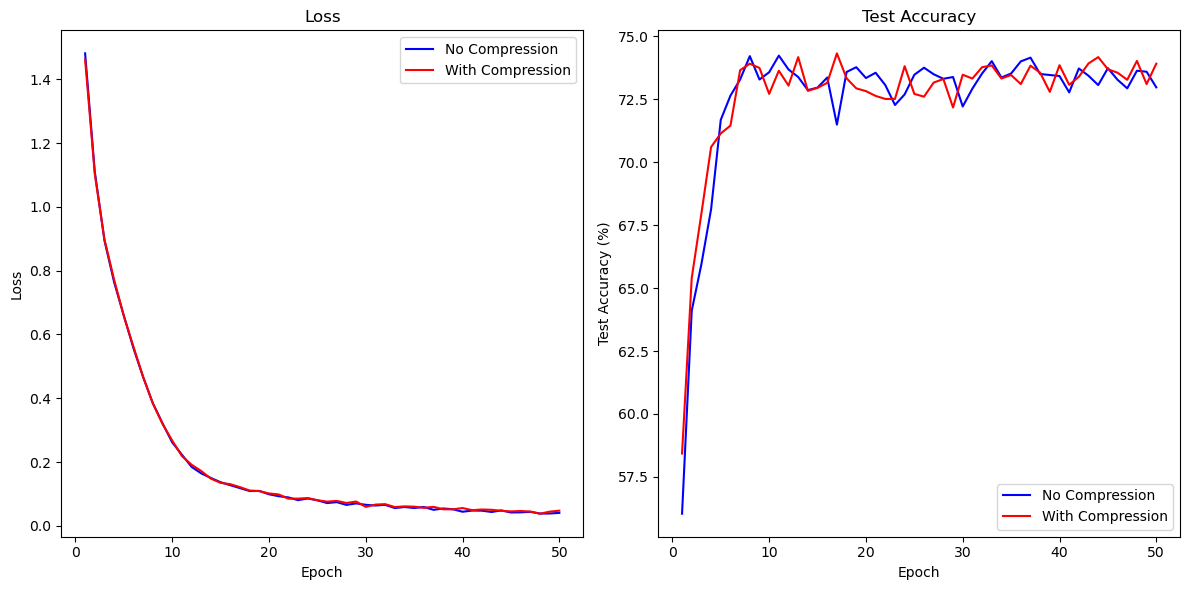

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import time
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import ResNet18_Weights

# Function to compress weights using MiniBatch K-means with initialization
def compress_weights_with_mini_batch_kmeans(weight_matrix, s, batch_size=2048, init_centroids=None):
    # Flatten the weight matrix into a 1D array
    flattened_weights = weight_matrix.flatten().reshape(-1, 1)
    
    # If no initial centroids are provided, use k-means++ initialization
    if init_centroids is None:
        init_centroids = 'k-means++'

    # Apply MiniBatchKMeans to cluster the weights into 's' clusters
    kmeans = MiniBatchKMeans(n_clusters=s, batch_size=batch_size, n_init=1, random_state=0, init=init_centroids)
    kmeans.fit(flattened_weights)
    
    # Get the labels and the cluster centers
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_.flatten()
    
    # Reassign weights to the cluster centers (compressed weights)
    compressed_weights = centroids[labels].reshape(weight_matrix.shape)
    
    # Return the compressed weights as a tensor and the centroids
    return torch.tensor(compressed_weights, dtype=torch.float32), kmeans.cluster_centers_

# Define the ResNet-18 model class with an option to compress weights
class ResNet18WithCompression(nn.Module):
    def __init__(self, compression=False, s=64):
        super(ResNet18WithCompression, self).__init__()

        self.model = models.resnet18(weights=None)
        self.compression = compression
        self.s = s

        for m in self.model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        return self.model(x)

    def compress_weights(self):
        if self.compression:
            last_residual_block = self.model.layer4[1]
            second_conv_layer = last_residual_block.conv2
            
            compressed_weights, centroids = compress_weights_with_mini_batch_kmeans(
                second_conv_layer.weight.data.cpu().numpy(), self.s
            )
            
            second_conv_layer.weight.data.copy_(compressed_weights.to(second_conv_layer.weight.device))
            return centroids

# Training function with compression (if enabled)
def train_with_compression(model, train_loader, test_loader, optimizer, criterion, epochs=50):
    model.train()
    losses = []
    test_accuracies = []  # Store test accuracies for each epoch
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.cuda(), target.cuda()  # Move data and target to GPU
            
            optimizer.zero_grad()  # Zero gradients before backward pass
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute the loss
            loss.backward()  # Backward pass
            
            optimizer.step()  # Update weights using the optimizer

            # Apply weight compression after each optimizer step if enabled
            if model.compression:
                with torch.no_grad():
                    centroids = model.compress_weights()  # Compress the weights

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        # After each epoch, evaluate on the test set
        test_accuracy = test_model(model, test_loader)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy}%")

        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds")

    return losses, test_accuracies

# Function to test the model's performance
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # No gradients are computed during testing
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader.dataset)  # Calculate accuracy on the test set
    return accuracy

# Main function to run the experiments
def main():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    # Load CIFAR-10 dataset
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform),
        batch_size=64, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform),
        batch_size=1000, shuffle=False
    )

    # Initialize and train the model without compression
    print("Training model without compression:")
    model_no_compression = ResNet18WithCompression(compression=False).cuda()
    optimizer_no_compression = optim.Adam(model_no_compression.parameters())
    criterion = nn.CrossEntropyLoss()

    # Train and test the model without compression
    losses_no_compression, test_accuracies_no_compression = train_with_compression(
        model_no_compression, train_loader, test_loader, optimizer_no_compression, criterion, epochs=50
    )

    # Initialize and train the model with compression
    print("\nTraining model with compression:")
    model_compression = ResNet18WithCompression(compression=True, s=64).cuda()
    optimizer_compression = optim.Adam(model_compression.parameters())

    # Train and test the model with compression
    losses_compression, test_accuracies_compression = train_with_compression(
        model_compression, train_loader, test_loader, optimizer_compression, criterion, epochs=50
    )

    # Plotting the loss and test accuracy comparison
    epochs_range = range(1, 51)
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, losses_no_compression, label='No Compression', color='b')
    plt.plot(epochs_range, losses_compression, label='With Compression', color='r')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies_no_compression, label='No Compression', color='b')
    plt.plot(epochs_range, test_accuracies_compression, label='With Compression', color='r')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()